In [1]:
import sys
sys.path.append('/scratch/cloned_repositories/keras-unet/')

import keras_unet

import glob
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
random_seed = 69

In [3]:
weights_dir = '/scratch/single_cell/EPFL/weights'

In [4]:
image_filenames = glob.glob("/scratch/single_cell/EPFL/raw/*.png")
label_filenames = glob.glob("/scratch/single_cell/EPFL/labels/data*.png")

image_filenames.sort()
label_filenames.sort()

In [5]:
images = []
labels = []

for image_filename, label_filename in zip(image_filenames, label_filenames):
    image = imageio.imread(image_filename)
    images.append(image)
    
    label = imageio.imread(label_filename)
    labels.append(label)

images = np.array(images, dtype=np.float32) / 255.
labels = np.array(labels, dtype=np.float32) / 255.

images = np.expand_dims(images, axis=-1)
labels = np.expand_dims(labels, axis=-1)

print(images.min(), images.max(), "    ", labels.min(), labels.max())
print(images.shape, "    ", labels.shape)

0.007843138 1.0      0.003921569 1.0
(165, 768, 1024, 1)      (165, 768, 1024, 1)


In [6]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.5, random_state=random_seed)
# x_train = images[: 83]
# y_train = labels[: 83]

# x_val = images[83: ]
# y_val = labels[83: ]

In [7]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (82, 768, 1024, 1)
y_train:  (82, 768, 1024, 1)
x_val:  (83, 768, 1024, 1)
y_val:  (83, 768, 1024, 1)


In [8]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [9]:
from keras_unet.models import custom_unet

input_shape = x_train[0].shape

model = custom_unet(
    input_shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 1024, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 768, 1024, 64 640         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 768, 1024, 64 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 1024, 64 36928       spatial_dropout2d[0][0]          
______________________________________________________________________________________________

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint


model_filename = 'custom_unet_v0.h5'  # next up: 'custom_unet_v0.0.0.1.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [12]:
from tensorflow.keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    #optimizer=Adam(), 
    optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded]
)

In [23]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    
    validation_data=(x_val, y_val),
    callbacks=[callback_checkpoint]
)

  ...
    to  
  ['...']
Train for 100 steps, validate on 83 samples
Epoch 1/10
 99/100 [============================>.] - ETA: 19s - loss: 0.2281 - iou: 0.8627 - iou_thresholded: 0.9286
Epoch 00001: val_loss improved from inf to 0.21937, saving model to custom_unet_v0.h5
100/100 [==============================] - 2126s 21s/step - loss: 0.2282 - iou: 0.8634 - iou_thresholded: 0.9287 - val_loss: 0.2194 - val_iou: 0.9398 - val_iou_thresholded: 0.9481
Epoch 2/10
 99/100 [============================>.] - ETA: 19s - loss: 0.1506 - iou: 0.9050 - iou_thresholded: 0.9465
Epoch 00002: val_loss improved from 0.21937 to 0.16539, saving model to custom_unet_v0.h5
100/100 [==============================] - 2142s 21s/step - loss: 0.1506 - iou: 0.9052 - iou_thresholded: 0.9465 - val_loss: 0.1654 - val_iou: 0.9044 - val_iou_thresholded: 0.9468
Epoch 3/10
 99/100 [============================>.] - ETA: 19s - loss: 0.2000 - iou: 0.8885 - iou_thresholded: 0.9390
Epoch 00003: val_loss did not improve fro

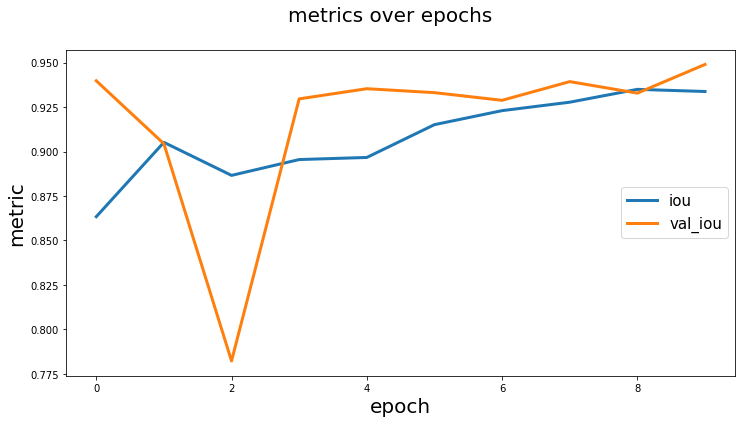

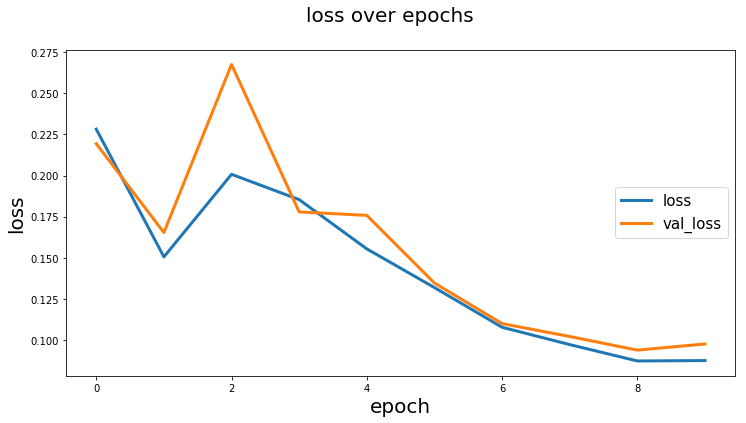

In [24]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [14]:
x_val[0:3].shape

(3, 768, 1024, 1)

In [15]:
model.load_weights(weights_dir + '/' + model_filename)
y_pred = model.predict(x_val[0:3])

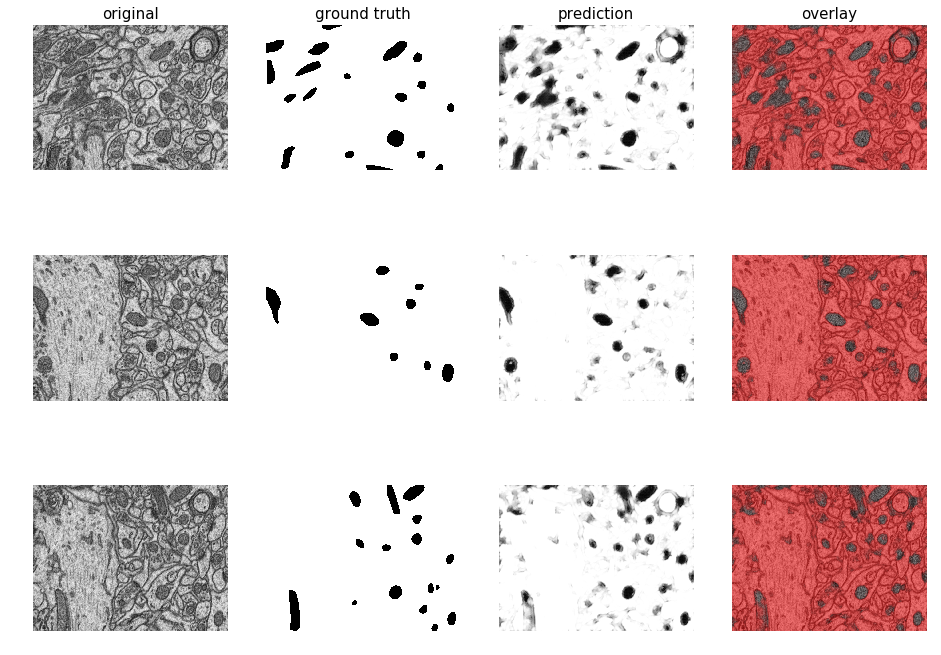

In [16]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=3)